## Notice: 

1.   Please add data augmentation code by yourself!
2.   Download submission.csv and submit to Kaggle


---










In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import pandas as pd
import imgaug.augmenters as iaa
import imgaug as ia

#### Download dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip dataset file 
# Plase Modify to your own file path!!!! 
!unzip -q '/content/drive/MyDrive/YZU(Yuan_Ze_University)/Classroom/EEB585A/Homework/Day_15/pneumonia-kaggle.zip'

#### Prepare dataset


In [ ]:
IMG_SIZE = 200
BATCH_SIZE = 64

all_class = ['normal', 'bacteria', 'virus']
class_map = {cls:i for i,cls in enumerate(all_class)} #  'normal':0, 'bacteria': 1, 'virus':2
class_map

{'normal': 0, 'bacteria': 1, 'virus': 2}

In [ ]:
# read all paths
img_paths_all = glob('pneumonia-kaggle/train/*/*.jpeg')
img_paths_test = sorted(glob('pneumonia-kaggle/test/*.jpeg'))
img_paths_train, img_paths_val = train_test_split(img_paths_all, test_size=0.2)

In [ ]:
# number of images
len(img_paths_train), len(img_paths_val), len(img_paths_test)

(4172, 1044, 624)

In [ ]:
class DataGenerator(utils.Sequence):
    def __init__(self, paths, batch_size, img_size, mode='train'):
        self.paths = paths
        self.batch_size = batch_size
        self.shuffle = mode == 'train'
        self.indexes = np.arange(len(self.paths))
        self.seq_aug = seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Flipud(0.5), # 50% vertical flip
            iaa.LinearContrast((0.4, 1.6)),
            iaa.AllChannelsCLAHE(),
            # iaa.AllChannelsHistogramEqualization(),
            iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
            iaa.Affine(
                rotate=(-10, 10), # random rotate -45 ~ +45 degree
                shear=(-16,16), # random shear -16 ~ +16 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
        ),
        ])
        all_class = ['normal', 'bacteria', 'virus']
        self.class_map = {cls:i for i,cls in enumerate(all_class)}
        self.num_classes = len(self.class_map)
        self.img_size = img_size
        self.mode = mode
        self.on_epoch_end()

    def __len__(self):
        'number of batches per epoch'
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        batch_paths = [self.paths[i] for i in idxs]
        # Generate data
        return self.__data_generation(batch_paths)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_augmentation(self, img):
        ''' function for apply some data augmentation '''
        return self.seq_aug.augment_image(img)
            
    def __data_generation(self, paths):
        """
        Generates data containing batch_size samples
        """
        x = np.empty((len(paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(paths)))

        for i, path in enumerate(paths):
            img = cv2.imread(path)[:,:,::-1]
            # img preprocess
            img = cv2.resize(img, (self.img_size, self.img_size))
            if self.mode == 'train':
                img = self.__data_augmentation(img)
            img = tf.keras.applications.vgg16.preprocess_input(img)
            if self.mode != 'test':
                # read class label
                cls = path.split(os.sep)[-2].lower()
                if cls == 'pneumonia':
                    # get filename
                    filename = path.split(os.sep)[-1]
                    # get pneumonia subclass
                    cls_pneumonia = filename.split('_')[1] 
                    cls_idx = class_map[cls_pneumonia]
                # for normal class
                else:
                    cls_idx = class_map[cls]
                y[i] = cls_idx
            x[i] = img

        if self.mode != 'test':            
            # one-hot encoding
            y = tf.keras.utils.to_categorical(y, num_classes=self.num_classes)
            return x, y
        else:
            return x

In [ ]:
gen_train = DataGenerator(img_paths_train, BATCH_SIZE, IMG_SIZE, mode='train')
gen_val = DataGenerator(img_paths_val, BATCH_SIZE, IMG_SIZE, mode='val')
gen_test = DataGenerator(img_paths_test, BATCH_SIZE, IMG_SIZE, mode='test')

### Build model

In [ ]:
base_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

x = layers.GlobalAveragePooling2D()(base_model.output) 
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(3, activation='softmax')(x)

for l in base_model.layers[:-2]:
    l.trainable = False

model = models.Model(base_model.input, x)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

#### Training

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
logs = model.fit(gen_train, epochs=100,
          callbacks=[
                     tf.keras.callbacks.EarlyStopping(patience=10),
                     tf.keras.callbacks.ModelCheckpoint('./best.h5', save_best_only=True,),
                     tf.keras.callbacks.ModelCheckpoint('./last.h5', save_best_only=False,),
                     tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.3, min_lr=9e-5),
          ],
          validation_data=gen_val)

Epoch 1/100
66/66 [==============================] - 137s 2s/step - loss: 1.7271 - accuracy: 0.5630 - val_loss: 0.5952 - val_accuracy: 0.7318 - lr: 0.0010
Epoch 2/100
66/66 [==============================] - 136s 2s/step - loss: 0.6608 - accuracy: 0.7049 - val_loss: 0.5777 - val_accuracy: 0.7471 - lr: 0.0010
Epoch 3/100
66/66 [==============================] - 135s 2s/step - loss: 0.6136 - accuracy: 0.7318 - val_loss: 0.5667 - val_accuracy: 0.7452 - lr: 0.0010
Epoch 4/100
66/66 [==============================] - 136s 2s/step - loss: 0.5990 - accuracy: 0.7361 - val_loss: 0.5676 - val_accuracy: 0.7567 - lr: 0.0010
Epoch 5/100
66/66 [==============================] - 136s 2s/step - loss: 0.5812 - accuracy: 0.7450 - val_loss: 0.5225 - val_accuracy: 0.7787 - lr: 0.0010
Epoch 6/100
66/66 [==============================] - 136s 2s/step - loss: 0.5783 - accuracy: 0.7529 - val_loss: 0.5263 - val_accuracy: 0.7663 - lr: 0.0010
Epoch 7/100
66/66 [==============================] - 135s 2s/step - lo

#### Training logs

In [ ]:
history = logs.history
min_loss_epoch = np.argmin(history['val_loss'])
print('val loss ', history['val_loss'][min_loss_epoch])
print('val acc', history['val_accuracy'][min_loss_epoch])

val loss  0.46867668628692627
val acc 0.7950191497802734


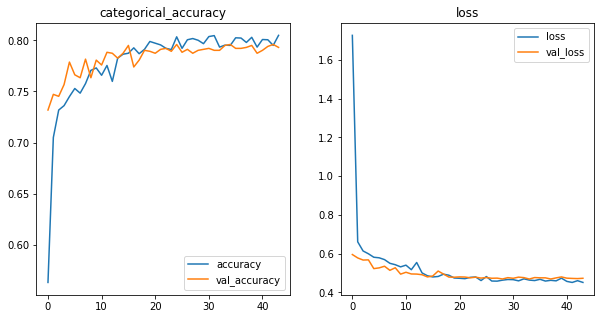

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('categorical_accuracy')
plt.subplot(1,2,2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')
plt.show()

#### Metrics

In [ ]:
# load best model
model.load_weights('best.h5') 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.array([])
y_true = np.array([])
for x_val, y_val in tqdm(gen_val):
    pred = model.predict(x_val)
    y_pred = np.append(y_pred, np.argmax(pred, axis=-1))
    y_true = np.append(y_true, np.argmax(y_val, axis=-1))

  0%|          | 0/17 [00:00<?, ?it/s]

1/1 [==============================] - 0s 153ms/step


In [ ]:
# classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       266
         1.0       0.79      0.85      0.82       512
         2.0       0.65      0.53      0.59       266

    accuracy                           0.80      1044
   macro avg       0.79      0.78      0.78      1044
weighted avg       0.79      0.80      0.79      1044



In [ ]:
# Confusion matrix:
#   row: Ground truth
#   column: predict
print(confusion_matrix(y_true, y_pred))

[[254   6   6]
 [  8 434  70]
 [ 17 107 142]]


#### Make Kaggle Submission

In [ ]:
predictions = np.argmax(model.predict(gen_test), axis=-1)

10/10 [==============================] - 14s 1s/step


In [ ]:
df = pd.DataFrame()
df['Id'] = [f'{i:03d}.jpeg' for i in range(len(img_paths_test))]
df['Category'] = predictions.astype(int)
df.to_csv('submission.csv', index=None)
df

,Id,Category
0,000.jpeg,2
1,001.jpeg,1
2,002.jpeg,1
3,003.jpeg,1
4,004.jpeg,0
...,...,...
619,619.jpeg,1
620,620.jpeg,0
621,621.jpeg,0
622,622.jpeg,1


In [ ]:
!cp submission.csv '/content/drive/MyDrive/YZU(Yuan_Ze_University)/Classroom/EEB585A/Homework/Day_15/submission.csv'

In [ ]:
!cp best.h5 '/content/drive/MyDrive/YZU(Yuan_Ze_University)/Classroom/EEB585A/Homework/Day_15/best.h5'
!cp last.h5 '/content/drive/MyDrive/YZU(Yuan_Ze_University)/Classroom/EEB585A/Homework/Day_15/last.h5'